# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figureX_swe_calc_in_excel.ipynb` is a copy of `figureX_swe_treatment_defined_by_deltaDCE` but removing most computation
### So we will just get the values needed for the excel spreadsheet, then make the final figure here 

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

---

In [3]:
# Constants 
colorpre='darkslategray'
colorpos='royalblue'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# colors by aspect for later figures
colorcontrolsouth = 'tan'
colorcontrolnorth = 'lightsteelblue'
colortreatmentsouth = 'darkorange'
colortreatmentnorth = 'darkblue'

# make a color pallett, for the 4 color treatment and control...
mypal = ['orange', 'tan', 'blue', 'lightsteelblue']

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way as we do for the delta dce
also the same code in `figure8_sdv_treatment_defined_by_deltadce.ipynb`

In [4]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

In [5]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [6]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

### Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [7]:
# previous method for SDV
ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, we do the same calculation for the new normalized methods (same as the deltaDCE)

In [8]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

## This is where we define **treatment** and **non-treatment** (*control*) areas 
#### so let's change this from defined by the `baf` polygons, to being defined by the `deltaDCE` nochange area
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

In [9]:
ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # previously defined as treatment where the baf is not nan
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

# Define treatment as where delta_dce_cat is in [2, 5, 6]
ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([2, 5, 6])
)

# Define control as where delta_dce_cat is in [1, 3, 4]
ds['sdv_diff_control_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([1, 3, 4])
)

In [10]:
# define treatments based on baf polygons, with previous normalization of BAF
ds['sdv_diff_treatment'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# define treatment based on baf polygons, with new normalization
# for the treatment and control, north and south with the new normalized sdv diff
# ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # this code is above 
# ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# define treatment based on delta dce with new normalization
# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == -1)

## There are Three Things Happening Here
1. SDV calculated as before, using all BAF polygons for normalization and treatment definition
2. SDV now normalized by the deltaDCE category 3, but still define treatment
3. SDV now normalized by the deltaDCE catgeory 3, *and* the treatment areas are defined by deltaDCE catgeories

In [11]:
# previous methods
print("Method 1: SDV normalized by BAF, treatment defined by BAF polygons")
print(f'median treatment: ', ds['sdv_diff_treatment'].median().round(2).values)
print(f'median control : ', ds['sdv_diff_control'].median().round(2).values)
print('')

# print the medians from the plot with the new normalized sdv diff
print("Method 2: SDV normalized by deltaDCE, treatment defined by BAF polygons")
print(f'median treatment new norm: ', ds['sdv_diff_treatment_new_norm'].median().round(2).values)
print(f'median control new norm: ', ds['sdv_diff_control_new_norm'].median().round(2).values)
print('')

print("Method 3: SDV normalized by deltaDCE, treatment defined by delta DCE categories")    
print(f'median treatment new norm cat: ', ds['sdv_diff_treatment_new_norm_cat'].median().round(2).values)
print(f'median control new norm cat: ', ds['sdv_diff_control_new_norm_cat'].median().round(2).values)

Method 1: SDV normalized by BAF, treatment defined by BAF polygons
median treatment:  0.16
median control :  -0.01

Method 2: SDV normalized by deltaDCE, treatment defined by BAF polygons
median treatment new norm:  0.36
median control new norm:  0.18

Method 3: SDV normalized by deltaDCE, treatment defined by delta DCE categories
median treatment new norm cat:  0.53
median control new norm cat:  0.1


# Relative Impact Calc for Abstract 
using median (or mean) values of the difference in standardized snow depth values (SDV) to calculate a relative treatment impact

In [17]:
# SDV Diff, north and south 

data = pd.DataFrame({
    'side': ['south', 'south',  'north', 'north'],
    'treatment': ['control',  'treatment', 'control',  'treatment'],
    'sdv_median': [ds['sdv_diff_control_south_new_norm_cat'].median().values.round(2),
                   ds['sdv_diff_treatment_south_new_norm_cat'].median().values.round(2),
                   ds['sdv_diff_control_north_new_norm_cat'].median().values.round(2),
                   ds['sdv_diff_treatment_north_new_norm_cat'].median().values.round(2)]  
})
data

,side,treatment,sdv_median
0,south,control,0.31
1,south,treatment,0.45
2,north,control,-0.40
3,north,treatment,0.62


In [23]:
deltaSDV = ds['sdv_diff_treatment_new_norm_cat'] - ds['sdv_diff_control_new_norm_cat']

# deltaSDV_south = ds['sdv_diff_treatment_south_new_norm_cat'] - ds['sdv_diff_control_south_new_norm_cat']
# deltaSDV_north = ds['sdv_diff_treatment_north_new_norm_cat'] - ds['sdv_diff_control_north_new_norm_cat']

deltaSDV_south = ds['sdv_diff_treatment_south_new_norm_cat'].median() - ds['sdv_diff_control_south_new_norm_cat'].median()
deltaSDV_north = ds['sdv_diff_treatment_north_new_norm_cat'].median() - ds['sdv_diff_control_north_new_norm_cat'].median()

# relative_impact = (deltaSDV_south - deltaSDV_north) / (deltaSDV_south + deltaSDV_north) # this could give normalized difference or effect contract ratio 
relative_impact = deltaSDV_north / deltaSDV_south # this takes the ratio to get a simple interpretable metric, such as 
#"The treatment impact on the north was X times that of the south"

print('Relative Impact (north/south): ', relative_impact.values.round(2))

Relative Impact (north/south):  7.41


## SWE Calculations 

If I wanted to keep both calculations to compare, I would un comment this block of code

In [12]:
## First way we did this, 
# ds['hs_rapid_zeros_removed_control'] = ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
# ds['hs_rapid_zeros_removed_treatment'] = ds['hs_rapid_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

# ds['hs_ncalm_zeros_removed_control'] = ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
# ds['hs_ncalm_zeros_removed_treatment'] = ds['hs_ncalm_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

# ds['hs_rapid_control_s'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_control_n'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] == -1)

# ds['hs_rapid_treatment_s'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_treatment_n'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] == -1)

# # Now do the same thing for the deltadce method of defining treatment areas 
# ds['hs_rapid_zeros_removed_control_cat'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
# ds['hs_rapid_zeros_removed_treatment_cat'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas 

# ds['hs_ncalm_zeros_removed_control_cat'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
# ds['hs_ncalm_zeros_removed_treatment_cat'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas

# ds['hs_rapid_control_cat_s'] = ds['hs_rapid_zeros_removed_control_cat'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_control_cat_n'] = ds['hs_rapid_zeros_removed_control_cat'].where(ds['baf_ridge'] == -1)

# ds['hs_rapid_treatment_cat_s'] = ds['hs_rapid_zeros_removed_treatment_cat'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_treatment_cat_n'] = ds['hs_rapid_zeros_removed_treatment_cat'].where(ds['baf_ridge'] == -1)

In [13]:
# ds['delta_dce_cat'].isin([2, 5, 6]) = treatment
# ds['delta_dce_cat'].isin([1, 3, 4]) = control (non-treatment)

But, I am simply going to replace the variable then rerun the entire notebook and see how it goes...

In [14]:
# Now do the same thing for the deltadce method of defining treatment areas 
ds['hs_rapid_zeros_removed_control'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
ds['hs_rapid_zeros_removed_treatment'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas 

ds['hs_ncalm_zeros_removed_control'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
ds['hs_ncalm_zeros_removed_treatment'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas

ds['hs_rapid_control_s'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_control_n'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] == -1)

ds['hs_rapid_treatment_s'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_treatment_n'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] == -1)

# Calculations
## Total Area

Total Area, in m2

In [15]:
# put the totals into a dataframe
total_area_m2 = pd.DataFrame({
                             'untreated on the south side': ds['hs_rapid_control_s'].count().values,
                             'treated on the south side': ds['hs_rapid_treatment_s'].count().values, # so these are with the zeros removed...
                             'untreated on the north side': ds['hs_rapid_control_n'].count().values,
                             'treated on the north side': ds['hs_rapid_treatment_n'].count().values,
                             }, index=[0])

total_area_m2 # in m2

,untreated on the south side,treated on the south side,untreated on the north side,treated on the north side
0,98572,97528,64910,112095


In [16]:
# convert the area in m2 to acres
total_area_acres = total_area_m2 / 4046.86 # 1 acre = 4046.86 m2
total_area_acres

,untreated on the south side,treated on the south side,untreated on the north side,treated on the north side
0,24.35765,24.099672,16.039596,27.699253


Total Area, in acres

In [17]:
# in km
total_area_km = total_area_m2/1000000
total_area_km.head()

,untreated on the south side,treated on the south side,untreated on the north side,treated on the north side
0,0.098572,0.097528,0.06491,0.112095


In [18]:
#lidar
ds['hs_control_n_sum'] = ds['hs_rapid_control_n'].sum(dim=['x','y'])
ds['hs_control_s_sum'] = ds['hs_rapid_control_s'].sum(dim=['x','y'])
ds['hs_treatment_n_sum']   = ds['hs_rapid_treatment_n'].sum(dim=['x','y'])
ds['hs_treatment_s_sum']   = ds['hs_rapid_treatment_s'].sum(dim=['x','y'])

# now, print all the totals 
print('treatment south: ', ds['hs_treatment_s_sum'].values)
print('treatment north: ', ds['hs_treatment_n_sum'].values)
print('untreated south: ', ds['hs_control_s_sum'].values)
print('untreated north', ds['hs_control_n_sum'].values)

treatment south:  [34276.98]
treatment north:  [59756.555]
untreated south:  [29752.566]
untreated north [26750.71]


## Now, calculating the total SWE for the area, 
* since we have 1 m res rasters, we have each count in the hist = 1 m^2 
* Thus, we can take the total SWE (below) and givide it by the total count for that variable to normalize between the group sizes 

In [19]:
# calculate SWE from a single snow density on each side of the ridge 
density = 310 

total_swe = pd.DataFrame({
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*density)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the south side': (ds['hs_treatment_s_sum'].values*density)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*density)/(ds['hs_rapid_control_n'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*density)/(ds['hs_rapid_treatment_n'].count().values),
                        })

total_swe.head()

,untreated on the south side,treated on the south side,untreated on the north side,treated on the north side
0,93.569127,108.951932,127.75721,165.257433


### Now, we are going to do this calculation with two different snow density measurements
1. with 310 kg/m3 (or 0.31% water) for everywhere
2. with 0.29 on the north and 0.34 on the south to see how the dense snow on the south side makes a difference in SWE totals 

In [20]:
# calculate SWE with different snow densities for north and south
densitynorth  =290
densitysouth = 340

total_swe_2 = pd.DataFrame({
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*densitysouth)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the south side': (ds['hs_treatment_s_sum'].values*densitysouth)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*densitynorth)/(ds['hs_rapid_control_n'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*densitynorth)/(ds['hs_rapid_treatment_n'].count().values),
                        })

total_swe_2.head()

,untreated on the south side,treated on the south side,untreated on the north side,treated on the north side
0,102.624204,119.495663,119.514805,154.595655


Now, the area and SWE / mm are added into Susan's spreadsheet, and the total water in acre-feet is calculated 

In [21]:
swe_acreft_31 = pd.DataFrame({'untreated south': 7.5,
                             'treated south': 8.6,
                             'untreated north': 6.7,
                             'treated north': 15.0,}, index=[0])

swe_acreft_34_29 = pd.DataFrame({  
                               'untreated south': 8.2,
                               'treated south': 9.4,
                               'untreated north': 6.3,
                               'treated north': 14.0,}, index=[0])
swe_acreft_31.head()
swe_acreft_34_29.head()

,untreated south,treated south,untreated north,treated north
0,8.2,9.4,6.3,14.0


Change the colors so that it matches Figure 8, treated and untreated, but then we are going to add dashed boxes as outlines to show north and south instead of new colors

# Figures

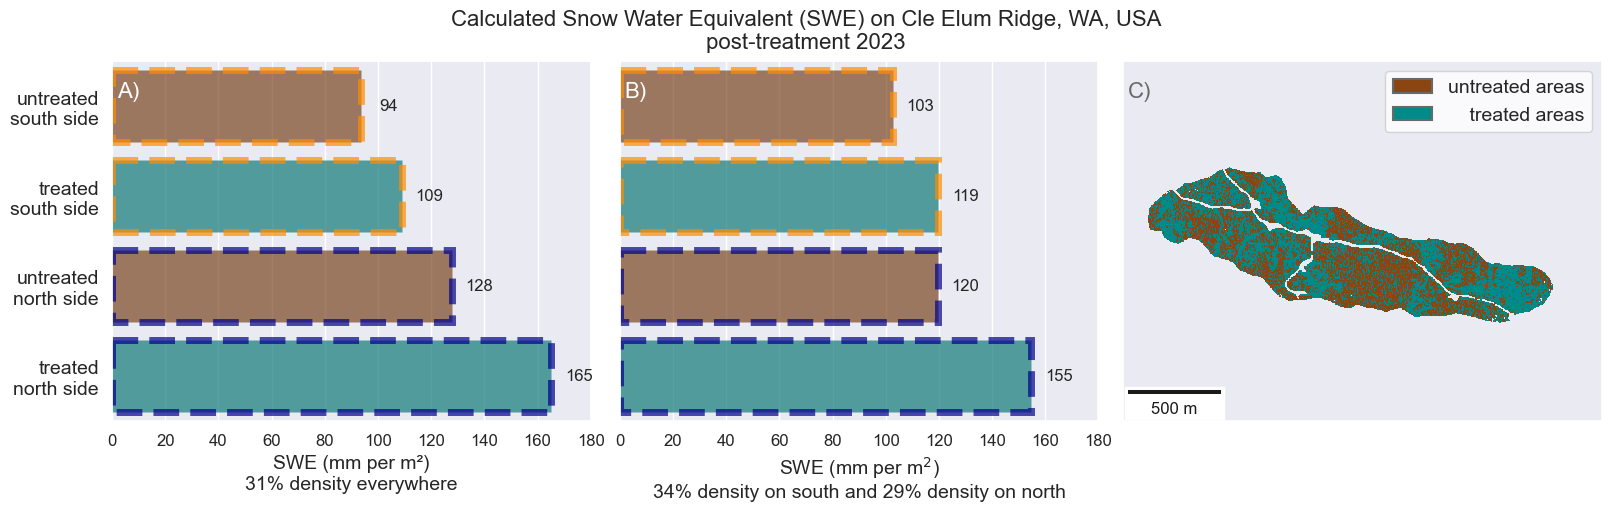

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

alpha = 0.7

# === PLOT A ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0], alpha=alpha)
axes[0].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
# axes[0].set_yticklabels(['treated\nsouth side', 'untreated\nsouth side', 'treated\nnorth side', 'untreated\nnorth side'], fontsize=14)
axes[0].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar

# === PLOT B ===
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1], alpha=alpha)
axes[1].set_xlabel('SWE (mm per m$^2$)\n34% density on south and 29% density on north', fontsize=14)
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points')

# === PLOT C ===

color_zero = '#EAEAF2'
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "   treated areas"}

axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel('')
axes[2].set_ylabel('')


# Add scalebar
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') # this is the origional code 
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left', rotation='horizontal-only') # this is updated to surpress the warning for scaling if we do not use 1:1 aspect ratio
# axes[2].set_aspect(1) # this would alter the size of the subplot #3, but also would make the aspect ratio 1:1 if we needed
axes[2].add_artist(scalebar)

# Internal legend (top right of subplot C)
legend_labels2 = {
    colorcontrol:  "untreated areas",
    colortreatment:"    treated areas"}

# patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
patches2 = [
    Patch(facecolor=color, label=label, edgecolor='dimgrey', linewidth=1.5)
    for color, label in legend_labels2.items()
] # this is adding a dimgrey box around the legend boxes 

axes[2].legend(
    handles=patches2,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor="white",
    fontsize=14
)

# === SOME CONSTANTS ===

# add outlines to the bar plots to show if it's south or north 
linewidth = 5
for bar in axes[0].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[0].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)
    
for bar in axes[1].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[1].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

# add A), B), and C), 
axes[2].set_title('') # removing the random title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
axes[2].text(0.01, 0.90, 'C)', fontsize=16, color='dimgrey', transform=axes[2].transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 180)
axes[1].set_xlim(0, 180)

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figureX_swe.png', dpi=500)

plt.show()

with water storage..?

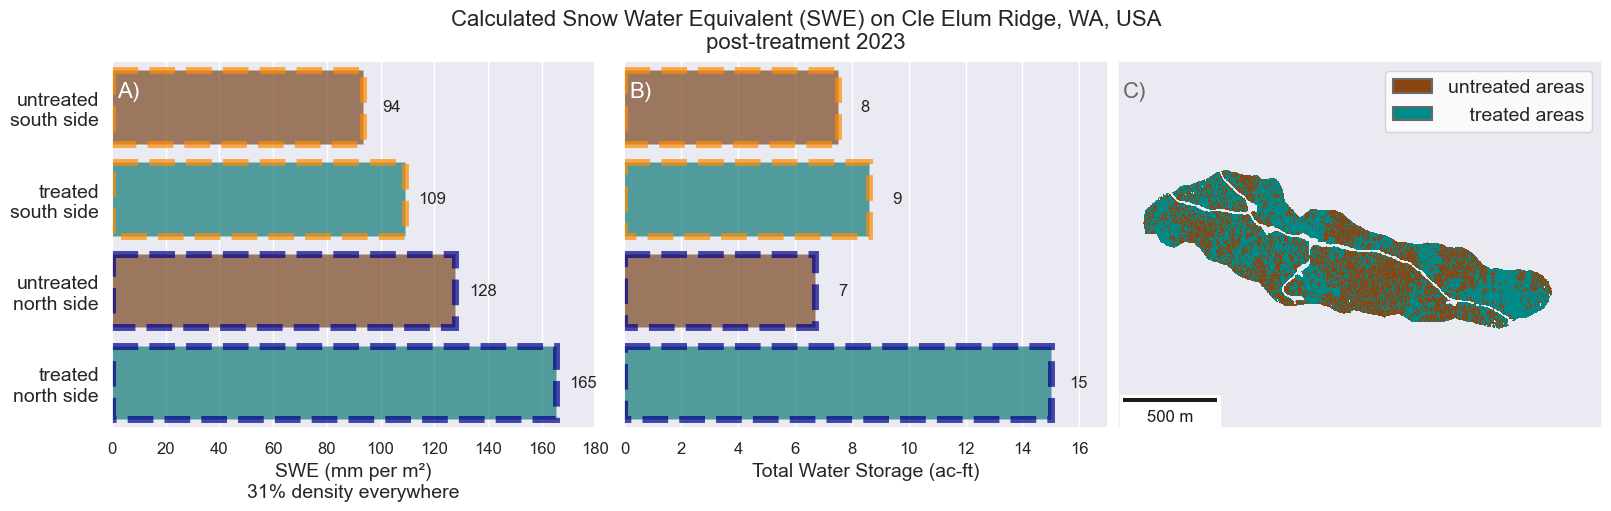

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

alpha = 0.7

# === PLOT A ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0], alpha=alpha)
axes[0].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
# axes[0].set_yticklabels(['treated\nsouth side', 'untreated\nsouth side', 'treated\nnorth side', 'untreated\nnorth side'], fontsize=14)
axes[0].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar

# === PLOT B ===
sns.barplot(swe_acreft_31, orient='h', palette=mypal2, ax=axes[1], alpha=alpha)
axes[1].set_xlabel('Total Water Storage (ac-ft)', fontsize=14)
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points')

# === PLOT C ===

color_zero = '#EAEAF2'
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "   treated areas"}

axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel('')
axes[2].set_ylabel('')

# Add scalebar
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') # this is the origional code 
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left', rotation='horizontal-only') # this is updated to surpress the warning for scaling if we do not use 1:1 aspect ratio
# axes[2].set_aspect(1) # this would alter the size of the subplot #3, but also would make the aspect ratio 1:1 if we needed
axes[2].add_artist(scalebar)

# Internal legend (top right of subplot C)
legend_labels2 = {
    colorcontrol:  "untreated areas",
    colortreatment:"    treated areas"}

# patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
patches2 = [
    Patch(facecolor=color, label=label, edgecolor='dimgrey', linewidth=1.5)
    for color, label in legend_labels2.items()
] # this is adding a dimgrey box around the legend boxes 

axes[2].legend(
    handles=patches2,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor="white",
    fontsize=14
)

# === SOME CONSTANTS ===

# add outlines to the bar plots to show if it's south or north 
linewidth = 5
for bar in axes[0].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[0].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)
    
for bar in axes[1].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[1].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

# add A), B), and C), 
axes[2].set_title('') # removing the random title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
axes[2].text(0.01, 0.90, 'C)', fontsize=16, color='dimgrey', transform=axes[2].transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 180)
axes[1].set_xlim(0, 17)

# adjust the tick marks on the axes[1] sp that they only show 0, 5, 10, 15, 20
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))  # format as integers
# axes[1].tick_params(axis='x', which='major', labelsize=12)

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figure9_swe_v2.png', dpi=500)

plt.show()

add area?

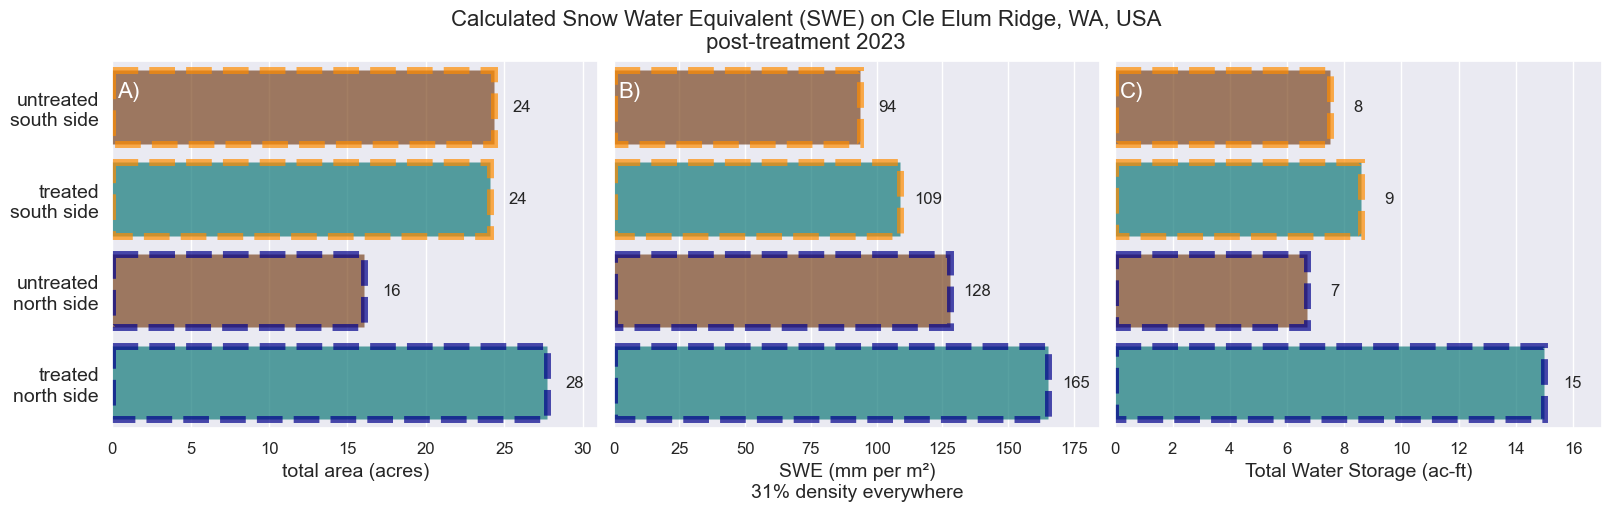

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

alpha = 0.7

# === PLOT A ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_area_acres, orient='h', palette=mypal2, ax=axes[0], alpha=alpha)
axes[0].set_xlabel('total area (acres)', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
axes[0].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar
    

# === PLOT B ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[1], alpha=alpha)
axes[1].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[1].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[1].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[1].set_yticklabels('')
axes[1].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar

# === PLOT C ===
sns.barplot(swe_acreft_31, orient='h', palette=mypal2, ax=axes[2], alpha=alpha)
axes[2].set_xlabel('Total Water Storage (ac-ft)', fontsize=14)
axes[2].set_yticks([])
axes[2].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[2].patches:
    axes[2].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points')

# === PLOT D?? the map if we want it somewhere===

# color_zero = '#EAEAF2'
# ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# # Add a legend for labels, to have different labels for each plot
# legend_labels2 = {colorcontrol:   "untreated areas", 
#                   colortreatment: "   treated areas"}

# axes[2].set_xticks([])
# axes[2].set_yticks([])
# axes[2].set_xlabel('')
# axes[2].set_ylabel('')

# # Add scalebar
# # scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') # this is the origional code 
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left', rotation='horizontal-only') # this is updated to surpress the warning for scaling if we do not use 1:1 aspect ratio
# # axes[2].set_aspect(1) # this would alter the size of the subplot #3, but also would make the aspect ratio 1:1 if we needed
# axes[2].add_artist(scalebar)

# # Internal legend (top right of subplot C)
# legend_labels2 = {
#     colorcontrol:  "untreated areas",
#     colortreatment:"    treated areas"}

# # patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
# patches2 = [
#     Patch(facecolor=color, label=label, edgecolor='dimgrey', linewidth=1.5)
#     for color, label in legend_labels2.items()
# ] # this is adding a dimgrey box around the legend boxes 

# axes[2].legend(
#     handles=patches2,
#     loc='upper right',
#     bbox_to_anchor=(1, 1),
#     frameon=True,
#     facecolor="white",
#     fontsize=14
# )

# === SOME CONSTANTS ===

# add outlines to the bar plots to show if it's south or north 
linewidth = 5
for bar in axes[0].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[0].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)
    
for bar in axes[1].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[1].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)
    
for bar in axes[2].patches[:2]:
    bar.set_edgecolor(colorsouth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

for bar in axes[2].patches[2:]:
    bar.set_edgecolor(colornorth)
    bar.set_linestyle('--')
    bar.set_linewidth(linewidth)

# add A), B), and C), 
# axes[2].set_title('') # removing the random title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
axes[2].text(0.01, 0.90, 'C)', fontsize=16, color='white', transform=axes[2].transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 31)
axes[1].set_xlim(0, 185)
axes[2].set_xlim(0, 17)

axes[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))  # format as integers

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figure9_swe.png', dpi=500)

plt.show()

Now, let's try to add stripes instead of the outline...

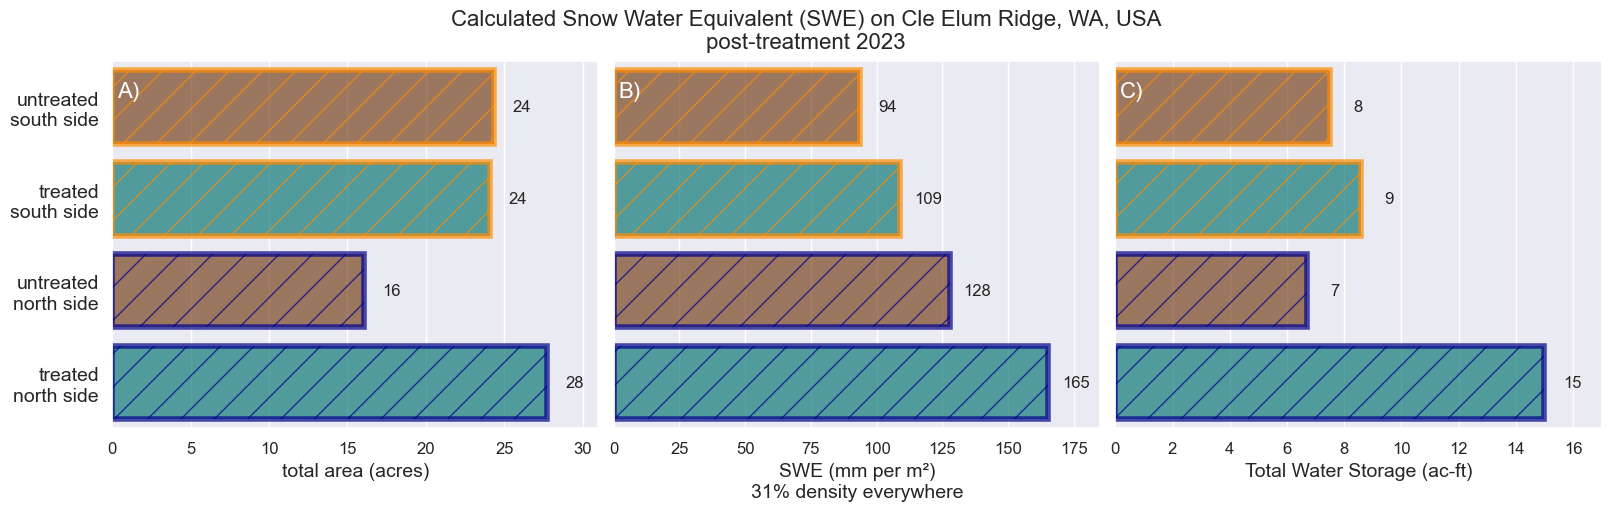

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

alpha = 0.7

# === PLOT A ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_area_acres, orient='h', palette=mypal2, ax=axes[0], alpha=alpha)
axes[0].set_xlabel('total area (acres)', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
axes[0].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar
    

# === PLOT B ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[1], alpha=alpha)
axes[1].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[1].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[1].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[1].set_yticklabels('')
axes[1].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar

# === PLOT C ===
sns.barplot(swe_acreft_31, orient='h', palette=mypal2, ax=axes[2], alpha=alpha)
axes[2].set_xlabel('Total Water Storage (ac-ft)', fontsize=14)
axes[2].set_yticks([])
axes[2].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[2].patches:
    axes[2].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points')


# === SOME CONSTANTS ===
# === ADD STRIPES TO BARS ===
linewidth = 4
for i, patch in enumerate(axes[0].patches):
    if i < 2:
        patch.set_hatch('/')
        patch.set_edgecolor(colorsouth)
    else:
        patch.set_hatch('/')
        patch.set_edgecolor(colornorth)
    patch.set_linewidth(linewidth)
    
# === ADD STRIPES TO BARS ===
for i, patch in enumerate(axes[1].patches):
    if i < 2:
        patch.set_hatch('/')
        patch.set_edgecolor(colorsouth)
    else:
        patch.set_hatch('/')
        patch.set_edgecolor(colornorth)
    patch.set_linewidth(linewidth)
    
# === ADD STRIPES TO BARS ===
for i, patch in enumerate(axes[2].patches):
    if i < 2:
        patch.set_hatch('/')
        patch.set_edgecolor(colorsouth)
    else:
        patch.set_hatch('/')
        patch.set_edgecolor(colornorth)
    patch.set_linewidth(linewidth)

# add A), B), and C), 
# axes[2].set_title('') # removing the random title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
axes[2].text(0.01, 0.90, 'C)', fontsize=16, color='white', transform=axes[2].transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 31)
axes[1].set_xlim(0, 185)
axes[2].set_xlim(0, 17)

axes[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))  # format as integers

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figure9_swe.png', dpi=500)

plt.show()

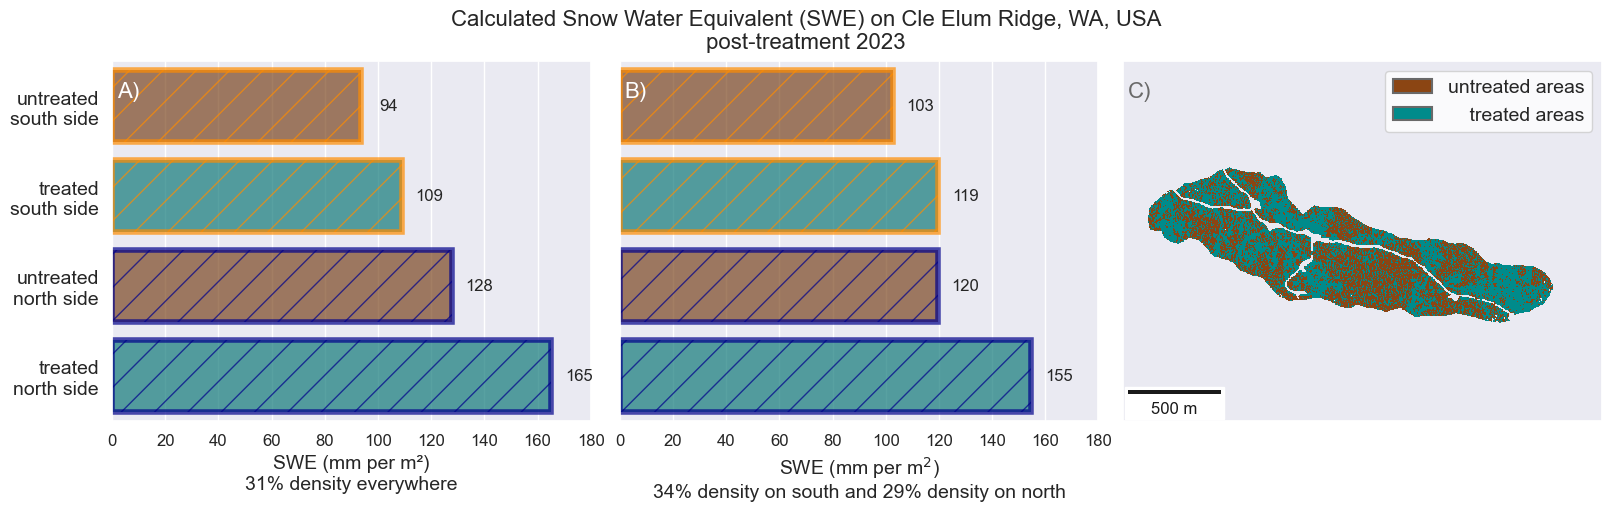

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

alpha = 0.7

# === PLOT A ===
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]
mypal2 = [colorcontrol, colortreatment, colorcontrol, colortreatment]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0], alpha=alpha)
axes[0].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
# axes[0].set_yticklabels(['treated\nsouth side', 'untreated\nsouth side', 'treated\nnorth side', 'untreated\nnorth side'], fontsize=14)
axes[0].set_yticklabels(['untreated\nsouth side', 'treated\nsouth side', 'untreated\nnorth side', 'treated\nnorth side', ], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points') # xytext(10,0) is where we put the text, 10 pixels to the right of the bar

# === PLOT B ===
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1], alpha=alpha)
axes[1].set_xlabel('SWE (mm per m$^2$)\n34% density on south and 29% density on north', fontsize=14)
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelsize=12)

# this is where we add the numbers to the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(20, 0), textcoords='offset points')

# === PLOT C ===

color_zero = '#EAEAF2'
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "   treated areas"}

axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_xlabel('')
axes[2].set_ylabel('')


# Add scalebar
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') # this is the origional code 
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left', rotation='horizontal-only') # this is updated to surpress the warning for scaling if we do not use 1:1 aspect ratio
# axes[2].set_aspect(1) # this would alter the size of the subplot #3, but also would make the aspect ratio 1:1 if we needed
axes[2].add_artist(scalebar)

# Internal legend (top right of subplot C)
legend_labels2 = {
    colorcontrol:  "untreated areas",
    colortreatment:"    treated areas"}

# patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
patches2 = [
    Patch(facecolor=color, label=label, edgecolor='dimgrey', linewidth=1.5)
    for color, label in legend_labels2.items()
] # this is adding a dimgrey box around the legend boxes 

axes[2].legend(
    handles=patches2,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor="white",
    fontsize=14
)

# === SOME CONSTANTS ===

# === ADD STRIPES TO BARS ===
linewidth = 4
for i, patch in enumerate(axes[0].patches):
    if i < 2:
        patch.set_hatch('/')
        patch.set_edgecolor(colorsouth)
    else:
        patch.set_hatch('/')
        patch.set_edgecolor(colornorth)
    patch.set_linewidth(linewidth)
    
# === ADD STRIPES TO BARS ===
for i, patch in enumerate(axes[1].patches):
    if i < 2:
        patch.set_hatch('/')
        patch.set_edgecolor(colorsouth)
    else:
        patch.set_hatch('/')
        patch.set_edgecolor(colornorth)
    patch.set_linewidth(linewidth)

# add A), B), and C), 
axes[2].set_title('') # removing the random title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
axes[2].text(0.01, 0.90, 'C)', fontsize=16, color='dimgrey', transform=axes[2].transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 180)
axes[1].set_xlim(0, 180)

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figure9_swe.png', dpi=500)

plt.show()

# What about by BAF polygons?

### I want to create a BAF map to compare with the deltaDCE map... 
#### but we want to be careful to exclude the BAF polygons which are not treated..
The following polygons are not treated, 

> South Side of the Ridge, 
* Leave Gap (BAF 0)
* BA 30 (no treatments)
* Leave Forest (BAF 155)
* Then there is another BAF 155 listed for the south... as not having treatments performed...


> North Side of the Ridge, 
* Leave Gap (BAF 0)
* Leave Forest (BAF XX) 

### honestly, this gets a bit complicated. 
I am interested to see the true results, but don't have time now to compute this properly. 

so I'll leave the notes here for now and perhaps come back to this